### Let's demonstrate the image formation pipeline in ``cryojax``.

In [1]:
# Jax imports
import equinox as eqx
import jax
import jax.numpy as jnp
import numpy as np
from jax import config

config.update("jax_enable_x64", True)

In [2]:
# Plotting imports and function definitions
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_image(image, fig, ax, cmap="gray", label=None, **kwargs):
    im = ax.imshow(image, cmap=cmap, origin="lower", **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    if label is not None:
        ax.set(title=label)
    return fig, ax

In [3]:
# Image simulator imports
import cryojax.simulator as cs
from cryojax.image import operators as op
from cryojax.io import read_array_with_spacing_from_mrc

In [4]:
# Volume filename and metadata
filename = "../tests/data/3j9g_bfm1_ps4_4.mrc"

First we must read in our template into a given volume representation of the ``Specimen``. We also must choose its ``Pose``.

In [5]:
# Read template into either an ElectronCloud or ElectronGrid
real_voxel_grid, voxel_size = read_array_with_spacing_from_mrc(filename)
potential = cs.FourierVoxelGrid.from_real_voxel_grid(
    real_voxel_grid, voxel_size, pad_scale=2
)
pose = cs.EulerPose(
    offset_x=-2.0, offset_y=5.0, view_phi=-4.0, view_theta=20.0, view_psi=20.0
)
specimen = cs.Specimen(potential, pose)

Next we have to choose an integration method onto the exit plane. This will depend on the scattering potential representation.

In [11]:
# Configure the image formation process
shape = (65, 65)
pixel_size = 4.4  # Angstroms
config = cs.ImageConfig(shape, pixel_size, pad_scale=2)
integrator = cs.FourierSliceExtract(
    config, interpolation_order=1, interpolation_mode="fill"
)

Now, it's time to configure the imaging instrument.

In [12]:
# Initialize the instrument
dose = cs.ElectronDose(electrons_per_angstrom_squared=100.0)
optics = cs.WeakPhaseOptics(
    ctf=cs.CTF(defocus_u=10000.0, defocus_v=10000.0, amplitude_contrast_ratio=0.07)
)
detector = cs.PoissonDetector(dqe=cs.IdealDQE(fraction_detected_electrons=1.0))
instrument_with_optics = cs.Instrument(optics)
instrument_with_optics_and_detector = cs.Instrument(optics, dose, detector)

Now, choose a model for the solvent. By default, this is just ``NullIce``. Here, we model the ice as gaussian colored noise with ``GaussianIce``.

In [13]:
# Then, choose a model for the solvent
solvent = cs.GaussianIce(
    variance=op.Lorenzian(amplitude=0.002**2, scale=4 * config.pixel_size)
)

Finally, we can initialize our `ImagePipeline`s

In [14]:
# Image formation models
scattering_pipeline = cs.ImagePipeline(
    integrator=integrator, specimen=specimen, solvent=solvent
)
optics_pipeline = cs.ImagePipeline(
    integrator=integrator,
    specimen=specimen,
    instrument=instrument_with_optics,
    solvent=solvent,
)
detector_pipeline = cs.ImagePipeline(
    integrator=integrator,
    specimen=specimen,
    instrument=instrument_with_optics_and_detector,
    solvent=solvent,
)

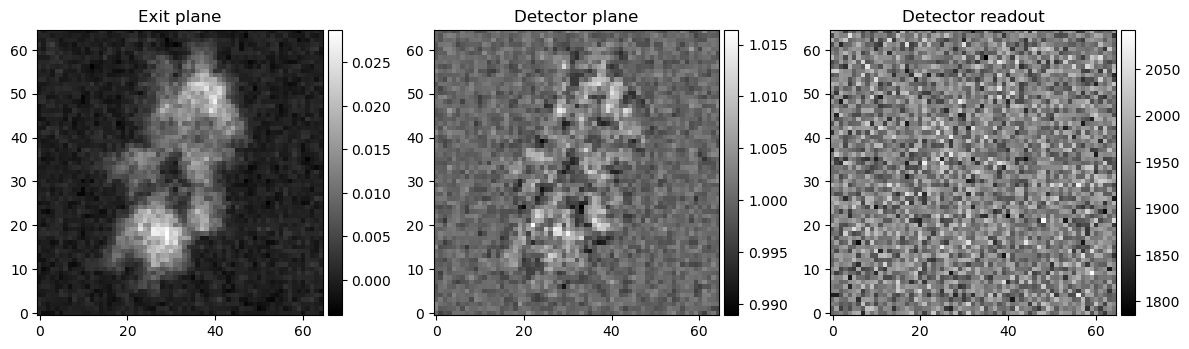

In [15]:
# Plot models
key = jax.random.PRNGKey(0)
fig, axes = plt.subplots(ncols=3, figsize=(12, 6))
ax1, ax2, ax3 = axes
im1 = plot_image(scattering_pipeline.sample(key), fig, ax1, label="Exit plane")
im2 = plot_image(optics_pipeline.sample(key), fig, ax2, label="Detector plane")
im3 = plot_image(detector_pipeline.sample(key), fig, ax3, label="Detector readout")
plt.tight_layout()